# <font color='red'>**Sequence to sequence implementation**</font>

### Implementation of Encoder and Decoder Model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. You have to implement a simple Encoder and Decoder architecture  

4. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

5. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

6.  a. Check the reference notebook <br>
    b. <a href="https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb">Resource 2</a>
    



<font color='blue'>**Load the data**</font>

In [3]:
# pip install nltk
# !pip install prettytable
# !pip install seaborn
# pip install --upgrade pip

In [1]:
import pandas as pd
import numpy as  np
import pandas as pd
import nltk
import re
from tqdm import tqdm
import tensorflow as tf
from nltk.corpus import stopwords
from prettytable import PrettyTable
import pickle
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from tensorflow.keras.activations import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
for device in tf.config.get_visible_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)
tf.config.experimental_run_functions_eagerly(True)
warnings.filterwarnings("ignore")
tf.compat.v1.enable_eager_execution()
tf.executing_eagerly()
from bs4 import BeautifulSoup

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [15]:
data = pd.read_csv('/kaggle/input/nmt-data/ita.txt', sep = '\t', header = None, names = ['English', 'Italian', 'Info'], usecols = [0, 1])
data.head()

,English,Italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
stop_words = set(stopwords.words('english')) 
def preprocess(text_data):
    def decontracted(phrase):
        # specific
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        return phrase
    text = []
    for sentance in tqdm(text_data):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        sentance = sentance.lower()
        text.append(sentance.strip())
    return np.array(text)

In [18]:
type(data.English.values)

numpy.ndarray

In [19]:
# Run if you want, you will get the data files in processed_data

eng = preprocess(data.English.values)
ita = preprocess(data.Italian.values)

100%|██████████| 354238/354238 [00:56<00:00, 6291.64it/s]


In [8]:
# eng = list(eng)
# ita = list(ita)

In [9]:
# eng = pd.DataFrame(eng)
# ita = pd.DataFrame(ita)
# eng.to_csv('eng_preprocessed.csv')
# ita.to_csv('ita_preprocessed.csv')

In [10]:
# eng = pd.read_csv('/kaggle/working/eng_preprocessed.csv')
# ita = pd.read_csv('/kaggle/working/ita_preprocessed.csv')
# eng = list(eng)
# ita = list(ita)

In [20]:
df = pd.DataFrame()
df['English']  = eng
df['Italian'] = ita
df.head(10)

,English,Italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte
5,who,chi
6,wow,wow
7,duck,amore
8,duck,tesoro
9,duck,immergiti


In [23]:
df.shape

(354238, 2)

In [24]:
df.to_csv('pre.csv')

### Till here, data gets pre-processed -  Stored in 'pre.csv'

In [25]:
df = pd.read_csv('//kaggle/working/pre.csv').iloc[:,1:]

df['Italian_len'] = df['Italian'].str.split().apply(len)
df['English_len'] = df['English'].str.split().apply(len)

df['Italian_len'] = df['Italian'].str.split().apply(len)
#df = df[df['Italian_len'] < 20]

df['English_len'] = df['English'].str.split().apply(len)
#df = df[df['English_len'] < 20]

df['English_inp'] = '<start> ' + df['English'].astype(str)
df['English_out'] = df['English'].astype(str) + ' <end>'

#df['Italian'] = '<start> ' + df['Italian'].astype(str)
#df['Italian'] = df['Italian'].astype(str) + ' <end>'

df = df.drop(['English','Italian_len','English_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
df.head()

,Italian,English_inp,English_out
0,ciao,<start> hi,hi <end>
1,ciao,<start> hi,hi <end>
2,corri,<start> run,run <end>
3,corra,<start> run,run <end>
4,correte,<start> run,run <end>


In [26]:
train, val = train_test_split(df, test_size = 0.2)

In [27]:
train.iloc[0]['English_inp'] = str(train.iloc[0]['English_inp'])+' <end>'
#train.iloc[0]['English_out'] = str(train.iloc[0]['English_out'])+' <end>'
train.head()

,Italian,English_inp,English_out
164281,una bottiglia di rosato per piacere,<start> a bottle of ros please <end>,a bottle of ros please <end>
26844,io la conosco bene,<start> i know her well,i know her well <end>
104792,ho trovato la scatola vuota,<start> i found the box empty,i found the box empty <end>
337087,ho qualche amico nel dipartimento di polizia,<start> i have some friends in the police depa...,i have some friends in the police department <...
322961,tom disse che voleva trasferirsi in australia,<start> tom said he wanted to move to australia,tom said he wanted to move to australia <end>


In [28]:
tknizer_ita = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_ita.fit_on_texts(train['Italian'].values)

tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['English_inp'].values)

In [29]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

12720
25094


In [30]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len_ita, max_len_eng):
        self.encoder_inps = data['Italian'].values
        self.decoder_inps = data['English_inp'].values
        self.decoder_outs = data['English_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len_eng = max_len_eng
        self.max_len_ita = max_len_ita

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len_ita, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len_eng, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len_eng, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

In [31]:
class Encoder(Model):
    def __init__(self, inp_vocab_size, embedding_size, lstm_size, input_length):
        super().__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size = lstm_size
        self.embed = Embedding(input_dim = self.inp_vocab_size, output_dim = self.embedding_size,
                               input_length = self.input_length, name="Encoder_Embedding")
        self.lstm = LSTM(units = self.lstm_size, return_sequences = True, return_state = True, name="Encoder_LSTM")
    def call(self, input_sequence, states = None):
          
        embed_out = self.embed(input_sequence)
        lstm_out, lstm_h, lstm_c = self.lstm(embed_out, states)
        return lstm_out, lstm_h, lstm_c

    def initialize_states(self,batch_size):
        states_h = tf.keras.backend.zeros((batch_size, self.lstm_size))
        state_c = tf.keras.backend.zeros((batch_size, self.lstm_size))
        return states_h, state_c   

In [32]:
# def grader_check_encoder():
#     '''
#         vocab-size: Unique words of the input language,
#         embedding_size: output embedding dimension for each word after embedding layer,
#         lstm_size: Number of lstm units,
#         input_length: Length of the input sentence,
#         batch_size
#     '''
#     vocab_size=10
#     embedding_size=20
#     lstm_size=32
#     input_length=10
#     batch_size=16
#     #Intialzing encoder 
#     encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
#     input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
#     #Intializing encoder initial states
#     initial_state=encoder.initialize_states(batch_size)
    
#     encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
#     assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
#     return True
# print(grader_check_encoder())

In [33]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.inp_vocab_size = out_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size = lstm_size
        self.embed = Embedding(input_dim = self.inp_vocab_size, output_dim = self.embedding_size,
                               input_length = self.input_length, name="Decoder_Embedding")
        self.lstm = LSTM(units = self.lstm_size, return_sequences = True, return_state = True, name="Decoder_LSTM")
  
    def call(self, output_sequence, initial_states):
        embed_out = self.embed(output_sequence)
        lstm_out, lstm_h, lstm_c = self.lstm(embed_out, initial_states)
        return lstm_out, lstm_h, lstm_c            

In [34]:
# def grader_decoder():
#     '''
#         out_vocab_size: Unique words of the target language,
#         embedding_size: output embedding dimension for each word after embedding layer,
#         dec_units: Number of lstm units in decoder,
#         input_length: Length of the input sentence,
#         batch_size
        
    
#     '''
#     out_vocab_size=13 
#     embedding_dim=12 
#     input_length=10
#     dec_units=16 
#     batch_size=32
    
#     target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
#     encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
#     state_h=tf.random.uniform(shape=[batch_size,dec_units])
#     state_c=tf.random.uniform(shape=[batch_size,dec_units])
#     states=[state_h,state_c]
#     decoder=Decoder(out_vocab_size,embedding_dim, dec_units,input_length )
#     output,_,_=decoder(target_sentences, states)
#     assert(output.shape==(batch_size,input_length,dec_units))
#     return True
# print(grader_decoder())


In [35]:
class Encoder_decoder(tf.keras.Model):
    def __init__(self, encoder_inputs_length, decoder_inputs_length, output_vocab_size):
        super().__init__()
        self.encoder = Encoder(inp_vocab_size = vocab_size_ita+1, embedding_size = 300, input_length = encoder_inputs_length,
                               lstm_size = 512)
        self.decoder = Decoder(out_vocab_size = vocab_size_eng+1, embedding_size = 300, input_length = decoder_inputs_length,
                               lstm_size = 512)
        self.dense = Dense(output_vocab_size, activation = 'softmax')
    
    def call(self, data):
        inp, targ = data[0], data[1]
        enc_out, state_h, state_c = self.encoder(inp)
        dec_out, _, _ = self.decoder(targ, [state_h, state_c])
        out = self.dense(dec_out)
        return out      

In [36]:
bs = 1024
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20, 20)
test_dataset  = Dataset(val, tknizer_ita, tknizer_eng, 20, 20)

train_dataloader = Dataloder(train_dataset, batch_size=bs)
test_dataloader = Dataloder(test_dataset, batch_size=bs)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [37]:
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model
model_1 = Encoder_decoder(encoder_inputs_length = 20, decoder_inputs_length = 20, output_vocab_size = vocab_size_eng)
model_1.compile('adam', loss = 'sparse_categorical_crossentropy')

In [38]:
# Try epochs = 50

early = tf.keras.callbacks.EarlyStopping(patience = 1, restore_best_weights = True)
model_1.fit(train_dataloader, epochs = 35, validation_data = (test_dataloader), steps_per_epoch = 150, validation_steps = 40, callbacks = [early])

Epoch 1/35
150/150 [==============================] - 61s 404ms/step - loss: 2.2718 - val_loss: 1.7254
Epoch 2/35
150/150 [==============================] - 60s 399ms/step - loss: 1.6534 - val_loss: 1.5526
Epoch 3/35
150/150 [==============================] - 60s 402ms/step - loss: 1.4601 - val_loss: 1.3751
Epoch 4/35
150/150 [==============================] - 60s 402ms/step - loss: 1.3124 - val_loss: 1.2428
Epoch 5/35
150/150 [==============================] - 60s 401ms/step - loss: 1.1720 - val_loss: 1.1141
Epoch 6/35
150/150 [==============================] - 61s 405ms/step - loss: 1.0530 - val_loss: 1.0097
Epoch 7/35
150/150 [==============================] - 60s 402ms/step - loss: 0.9493 - val_loss: 0.9155
Epoch 8/35
150/150 [==============================] - 60s 403ms/step - loss: 0.8489 - val_loss: 0.8208
Epoch 9/35
150/150 [==============================] - 60s 401ms/step - loss: 0.7499 - val_loss: 0.7263
Epoch 10/35
150/150 [==============================] - 60s 402ms/step - l

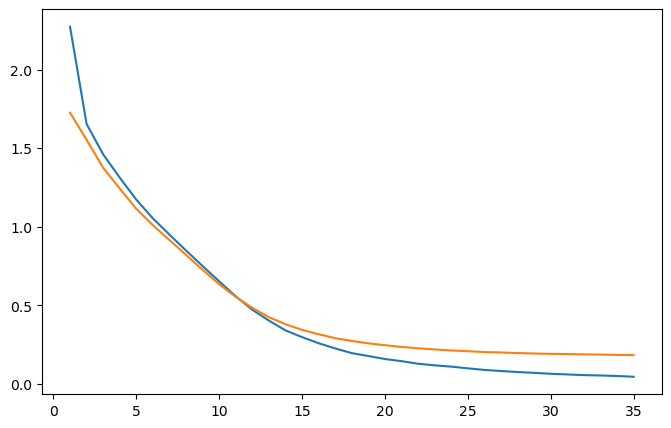

In [39]:
plt.figure(figsize = (8,5))
plt.plot(np.array(model_1.history.epoch)+1, model_1.history.history['loss'])
plt.plot(np.array(model_1.history.epoch)+1, model_1.history.history['val_loss'])
plt.show()

In [40]:
def predict(input_sentence):
    out_text = ''
    seq = tknizer_ita.texts_to_sequences([input_sentence]) 
    pad = pad_sequences(seq, maxlen = 20, dtype='int32', padding='post')
    enc_out, state_h, state_c = model_1.encoder(pad)
    intial = np.zeros((1,1), dtype = 'float32')
    intial[0, 0] = tknizer_eng.word_index['<start>']
    states = [state_h, state_c]
    
    for i in range(20):
        predicted_out, state_h, state_c = model_1.decoder(intial, initial_states = states)
        out = model_1.dense(predicted_out).numpy()
        out = out.reshape(out.shape[-1])
        states = [state_h, state_c] # Update State
        out = np.argmax(out)
        intial = np.zeros((1, 1), dtype = 'float32')
        if tknizer_eng.index_word[out] == '<end>' or i == 20:
            break
        intial[0, 0] = out #Update decoder input
        out_text += tknizer_eng.index_word[out] + ' '
    return out_text

In [41]:
res = pd.DataFrame()
res['Input'] = 0
res['Ground Truth'] = 0
res['Predicted'] = 0
res['Bleu Score'] = 0
m = np.random.randint(0, len(val), 10)
for n in tqdm(m):
    query = val.Italian.values[n]
    pred = predict(query)
    ground = val.English_inp.values[n][8:]
    ground_ = nltk.tokenize.casual.casual_tokenize(ground)
    pred_ = nltk.tokenize.casual.casual_tokenize(pred)
    bleu = nltk.translate.bleu_score.sentence_bleu([ground_], pred_) 
    res = res.append({'Input' : query, 'Ground Truth': ground, 'Predicted' : pred, 'Bleu Score' : bleu},ignore_index= True)
res

100%|██████████| 10/10 [00:00<00:00, 17.62it/s]


,Input,Ground Truth,Predicted,Bleu Score
0,perch sei cos magro,why are you so thin,why are you so thin,1.000000
1,sono sempre orgogliosa della mia famiglia,i am always proud of my family,i am always proud of my family,1.000000
2,queste sono difficili da fare,these are hard to make,these are hard to do,0.668740
3,questo cuscino molto comodo,this pillow is very uncomfortable,this pillow is very comfortable,0.668740
4,io non penso che tutti si siano arresi,i do not think everyone gave up,i do not think everyone gave up,1.000000
5,ho sentito cosa successo a tom,i heard what happened to tom,i heard what happened tom,0.578930
6,sono stata onesta con voi,i have been honest with you,i have been honest with you,1.000000
7,mi sei mancata un sacco,i have missed you a lot,i have missed you very much,0.508133
8,tom ha detto a tutti che era interessato,tom told everyone he was interested,tom told everyone he was interested,1.000000
9,voi morirete tutte,you will all die,you will all die,1.000000


In [42]:
model_1_bleu_score = np.mean(res['Bleu Score'].values)
print('Average Bleu Score: ', model_1_bleu_score)

Average Bleu Score:  0.8424543425574867
